Height is 4046, and width is 9216


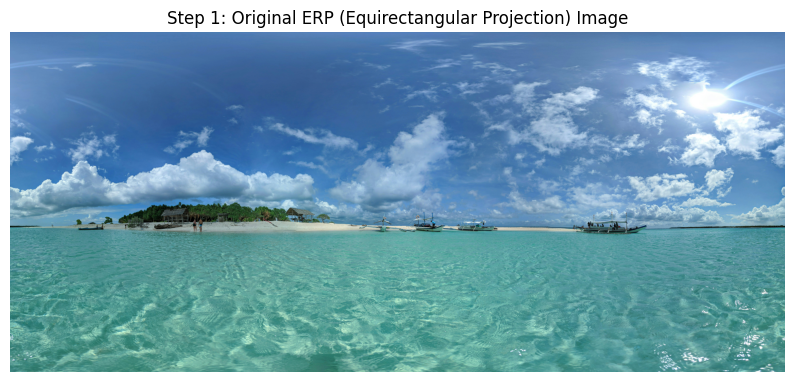

In [1]:
# ======================================
# 360° ERP Image → Spherical Projection Pipeline
# Steps 1–5
# ======================================

# STEP 1: Add and display image

# from google.colab import files

from IPython.display import Image as ColabImage
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

# Upload ERP image (e.g., Ocean360Picture.jpg)

# uploaded = files.upload()
# filename = list(uploaded.keys())[0]
# ColabImage(filename)

filename = "Ocean360Picture.jpg"

# Read image in RGB format
erp = cv2.imread(filename)
erp = cv2.cvtColor(erp, cv2.COLOR_BGR2RGB)
H, W, _ = erp.shape

print(f"Height is {H}, and width is {W}")

plt.figure(figsize=(10,5))
plt.imshow(erp)
plt.title("Step 1: Original ERP (Equirectangular Projection) Image")
plt.axis("off")
plt.show()

In [ ]:
widthDegree = 20
heightDegree = 20

num_lon_tiles = int(360 / widthDegree)  # 18
num_lat_tiles = int(180 / heightDegree)  # 9

# make 2d array of tiles, each index corersponds to a latitude and longitude index. Start with latitude indexing, sicne in images reference by (y, x)
tiles = [[[] for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]


for row in range (0, H, 1):
    for column in range (0, W, 1):
        pixel = erp[row][column]
        # this is like vertical distance. So first get fraction from 0-1,  get in range of 0-360, subtract by 180 to get range -180 to 180
        longitude = (column / W) * 360.0 - 180.0
        # so take fraction from 0 to 1, multiply by 180 to get range 0 to 180, subtract by 90 to get range 90 to -90
        latitude = 90.0 - (row / H) * 180.0 

        # print(f"Longitude is {longitude}, latitude is {latitude}")
        # print(f"Pixel data is: {pixel}")

        # want an index from 0 to num_lon_tiles. Get this by first adding longitude by 180 to get in range 0 - 360. Now, want lower values to mean lower indices (going left to right),
        # so now divide and get floor of widthDegree. So say 19 falls in tile 0, 20 falls in tile 1.
        tile_lon_index = int((longitude + 180) // widthDegree)
        # Same idea here as above. However, doing 180 subtracted is like flipping it, so smaller indices start at the top

        # technically we convert it from (180 - (latitude + 90) to (90 - latitude) as same meaning
        tile_lat_index = int((90 - latitude) // heightDegree)

        # now in the correct tile given by the 2d array, add this new pixel
        tiles[tile_lat_index][tile_lon_index].append([longitude, latitude])



In [ ]:
# we first decide on our tile width and derive height from it
tileWidth = int(W / num_lon_tiles)
tileHeight = int(round((H/W * tileWidth)))

print(f"Wdith will be {tileWidth}, height will be {tileHeight}")

# this will be the array of new tiles, where instead of each element being a list of pixels, its the actual image. same indices though
finalTiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

# === Step 5: Loop over each tile (lat × lon grid) ===
for lat_i in range(num_lat_tiles):
    # Latitude boundaries for this tile
    lat_max = 90.0 - lat_i * heightDegree    # top edge (starts from +90° at north pole)
    lat_min = lat_max - heightDegree         # bottom edge, go a single step down

    # Uniform sampling vertically: top to bottom
    lat_vals = np.linspace(lat_max, lat_min, tileHeight)

    # now, loop through each longitude (horizontally). Now can actually access each tile
    for lon_j in range(num_lon_tiles):
        
        # Longitude boundaries for this tile
        lon_min = lon_j * widthDegree - 180.0
        # to get max, go one stepi n this direction
        lon_max = lon_min + widthDegree

        # Uniform sampling horizontally: left to right
        lon_vals = np.linspace(lon_min, lon_max, tileHeight)

        # === Step 6: Make 2D grid of lat/lon for this tile ===
        lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
        # Shapes: (tile_H_out, tile_W_out)

        # === Step 7: Convert lat/lon → ERP pixel coordinates ===
        erp_x = (lon_grid + 180.0) / 360.0 * (W - 1)
        erp_y = (90.0 - lat_grid) / 180.0 * (H - 1)

        # === Step 8: Use OpenCV remap to sample the original ERP ===
        # remap expects float32 maps of pixel coordinates
        map_x = erp_x.astype(np.float32)
        map_y = erp_y.astype(np.float32)

        # BORDER_WRAP ensures pixels at longitude 180° wrap around correctly
        tile_img = cv2.remap(
            erp, map_x, map_y,
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_WRAP
        )

        # Save this tile
        finalTiles[lat_i][lon_j] = tile_img

        # Optional: visualize the first few tiles
        # plt.figure(figsize=(4, 2))
        # plt.imshow(tile_img)
        # plt.title(f"Tile lat:{lat_i} lon:{lon_j}")
        # plt.axis("off")
        # plt.show()


Wdith will be 512, height will be 225


Reconstructed ERP shape: (2025, 4050, 3)


(-0.5, 4049.5, 2024.5, -0.5)

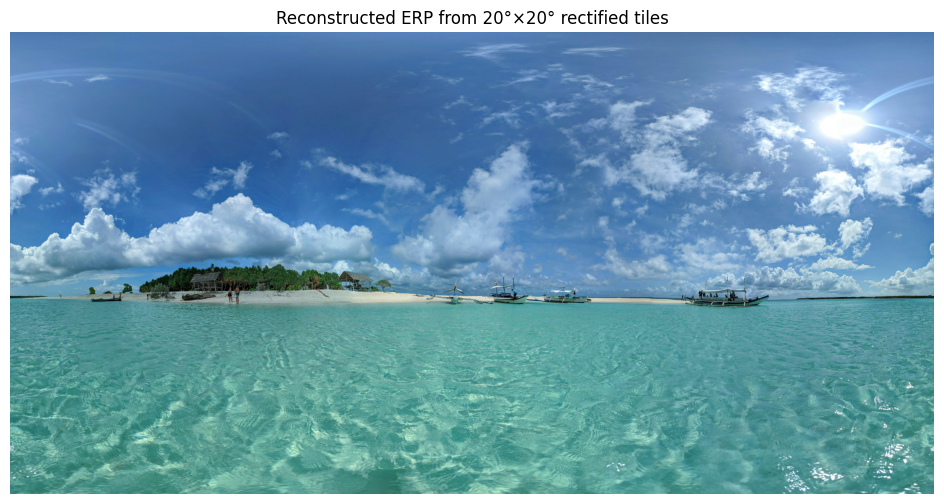

In [6]:
# === Step 9: Combine tiles back into a single ERP-like image ===

rows_combined = []
for lat_i in range(num_lat_tiles):
    # Stack all longitude tiles in this latitude row
    row_tiles = finalTiles[lat_i]
    row_img = np.hstack(row_tiles)
    rows_combined.append(row_img)

# Stack all latitude rows vertically (north → south)
erp_reconstructed = np.vstack(rows_combined)

print("Reconstructed ERP shape:", erp_reconstructed.shape)

plt.figure(figsize=(12, 6))
plt.imshow(erp_reconstructed)
plt.title("Reconstructed ERP from 20°×20° rectified tiles")
plt.axis("off")
